# Problem lavirinta



## Imports

In [28]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

import copy
import math
from PIL import Image

In [29]:
from abc import ABC, abstractmethod

## Parameters

Definisanje dimenzija lavirinta

In [30]:
''' Defines dimensions of the maze, ROWS*COLUMNS '''
ROWS = 10;
COLUMNS = 10;

''' Defining the number of each obstacles'''
NUMBER_OF_TRAPS = 10;
NUMBER_OF_TERMINALS = 3;
NUMBER_OF_ADDED_WALLS = 10;

''' Number of points that we get if steping on terminal or trap cell'''
REWARD_TERMINAL = 0;
REWARD_TRAP = -5;

''' Defining color for each obstacle coded in hex value'''
COLOUR_REGULAR = "#ffffff"      # white
COLOUR_WALL = "#A1A2A6"         # grey
COLOUR_PLAYER = "#14328C"       # blue
COLOUR_TERMINAL = "#3CA66A"     # green
COLOUR_TRAP = "#D92E1E"         # red
COLOUR_TELEPORT = "#F2B84B"     # yellow
COLOUR_TELEPORT_TO = "#F2D091"  # brighter yellow


## Classes

In [31]:
class Cell(ABC):
    '''Base class for everuy cell.'''
    @abstractmethod
    def get_reward(self) -> float:
        pass

In [32]:
class RegularCell(Cell):
    """A class that implements a regular cell - regular cells."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [33]:
class TrapCell(Cell):
    """A class that implements a trap cell - trap cells."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [34]:
class TerminalCell(Cell):
    """A class that implements a terminal cell."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [35]:
class TeleportCell():
  """A class that implements a teleport cell."""
  def __init__(self, reward: float, to_pos_x: int, to_pos_y: int):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
            to_pos_x (int): Defines the x coordinate that teleport points to.
            to_pos_y (int): Defines the y coordinate that teleport points to.
        """
        self.reward = reward
        self.to_pos_x = to_pos_x
        self.to_pos_y = to_pos_y

  def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [36]:
class WallCell(Cell):
    """A class that implements a wall cell."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward that player would never recieves.
        """
        return self.reward

In [37]:
class Player():
  def __init__(self, positionX: int, positionY: int, points=0):
      """Initialize the player.

      Args:
          positionX (int): Current position of the player on the x axis.
          positionY (int): Current position of the player on the y axis, starting from the top side of the table.
          points (int): Storing total reward throught game.

      """
      self.positionX = positionX
      self.positionY = positionY
      self.points = points

In [38]:
class Board():
    def __init__(self, rows: int, columns: int, initial_player_x: int, initial_player_y: int, initial_player_points = 0):
        """Initialize the board on which player/agent explores labyrinth.

        Args:
            rows (int): Defines the number of board rows.
            columns (int): Defines the number of board columns.
            initial_player_x (int): Defines the initial position of a player - x coordinate.
            initial_plyer_y (int): Defines the initial position of a player - y coordinate.
            initial_player_points (int): Defines the starting points that player has.
        """
        self.rows = rows
        self.columns = columns
        self.player_x = initial_player_x
        self.player_y = initial_player_y
        self.player_points = initial_player_points
        self.game_over = False
        self.state_list = []

        self.numbers = list(range((self.rows-2)*(self.columns-2)))
        # problem pravi ako se pozove addTerminalRandomly i ispostavi se da se igrac nalazi na toj poziciji

        ''' We form matrix that has dimensions rows*columns, but the outer ring of the matrix are walls'''
        self.board = [[WallCell(1) for i in range(columns)] for j in range(rows)]
        for i in range(rows):
          for j in range(columns):
            if i>=1 and i<rows-1 and j>=1 and j<columns-1:
              self.board[i][j] = RegularCell(-1)

    def change_cell(self, pos_x: int, pos_y: int, cell_type: Cell):
        ''' Changing the type of the cell on the position (pos_x, pos_y)
        '''
        self.board[pos_y][pos_x] = cell_type

    def addPlayerRandomly(self):
        ''' Method that randomly place player on the map.
        '''
        selected_number = random.choice(self.numbers)
        rand_player_y, rand_player_x = divmod(selected_number, (self.columns-2))
        self.numbers.remove(selected_number)
        self.move_player(rand_player_x+1, rand_player_y+1)

    def addTerminal(self, pos_x: int, pos_y:int, reward:int, override_cell = False):
        ''' Adding terminal cell on position (pos_x, pos_y) with specified reward.
        When parameter override_cell is True, than we can place terminal cell on occupied cell (trap, wall, teleport)
        '''
        new_x = pos_x-1
        new_y = pos_y-1
        selected_number = new_x + (self.rows-2)*new_y
        try:
          self.numbers.remove(selected_number)  # ako ovde pukne to znaci da tu vec ima nesto
          self.change_cell(pos_x, pos_y, TerminalCell(reward))
        except:
          if override_cell == True:
            self.change_cell(pos_x, pos_y, TerminalCell(reward))

    def addTeleport(self, reward:int, pos_x:int, pos_y:int, to_pos_x:int, to_pos_y:int, override_cell = False):
        # TODO uraditi proveru da li moze da se postavi tu teleport i tako to
        new_x = pos_x-1
        new_y = pos_y-1
        selected_number = new_x + (self.rows-2)*new_y

        try:
          self.numbers.remove(selected_number)  # ako ovde pukne to znaci da tu vec ima nesto
          self.change_cell(pos_x, pos_y, TeleportCell(reward, to_pos_x, to_pos_y))
        except:
          if override_cell == True:
            self.change_cell(pos_x, pos_y, TeleportCell(reward, to_pos_x, to_pos_y))


    def addTerminalRandomly(self, reward: int):
        ''' Method that randomly place terminal cell with specified reward.
        '''
        selected_number = random.choice(self.numbers)
        terminal_y, terminal_x = divmod(selected_number, (self.columns-2))
        self.numbers.remove(selected_number)
        self.change_cell(terminal_x+1, terminal_y+1, TerminalCell(reward))

    def addTrapRandomly(self, reward: int):
        ''' Method that randomly place trap cell with specified reward.
        '''
        selected_number = random.choice(self.numbers)
        terminal_y, terminal_x = divmod(selected_number, (self.columns-2))
        self.numbers.remove(selected_number)
        self.change_cell(terminal_x+1, terminal_y+1, TrapCell(reward))

    def addWallRandomly(self, reward=0):
        ''' Method that randomly place wall cell.
        '''
        selected_number = random.choice(self.numbers)
        terminal_y, terminal_x = divmod(selected_number, (self.columns-2))
        self.numbers.remove(selected_number)
        self.change_cell(terminal_x+1, terminal_y+1, WallCell(reward))

    def get_board(self):
        ''' Returns the board matrix with cells.'''
        return self.board

    def get_points(self):
        ''' Returns the current points that player has.'''
        return self.player_points

    def get_current_cell_reward(self):
        return self.board[self.player_y][self.player_x].get_reward()

    def update_points(self):
        ''' Updating current poins that player has with cell reward on his current position.'''
        self.player_points = self.player_points + self.board[self.player_y][self.player_x].get_reward()

    def move_player(self, pos_x: int, pos_y: int):
        ''' Moves player to the (pos_x, pos_y) if it's not a wall.'''
        if isinstance(self.board[pos_y][pos_x], TeleportCell):
          self.move_player(self.board[pos_y][pos_x].to_pos_x, self.board[pos_y][pos_x].to_pos_y)
          # Ovde problem moze da predstavlja ako se teleportuje na zid, jer je u tom slucaju nece pomeriti i stajace zakucan u mestu
          #self.player_x = self.board[pos_y][pos_x].to_pos_x
          #self.player_y = self.board[pos_y][pos_x].to_pos_y
          return True

        if not isinstance(self.board[pos_y][pos_x], WallCell):
          self.player_x = pos_x
          self.player_y = pos_y
          return True
        return False

    def is_game_over(self):
        ''' Checking if player is standing on a terminal cell. If it is, than that's the players wins.'''
        if isinstance(self.board[self.player_y][self.player_x], TerminalCell):
          self.game_over = True;
        return self.game_over

    def is_cell_terminal(self):
        ''' Checking if current cell is terminal.'''
        if isinstance(self.board[self.player_y][self.player_x], TerminalCell):
          return True
        else:
          return False

    def move_up(self):
        ''' Moving player one cell up.'''
        is_moved = self.move_player(self.player_x, self.player_y - 1)
        self.update_points()
        self.is_game_over()
        return is_moved

    def move_down(self):
        ''' Moving player one cell down.'''
        is_moved = self.move_player(self.player_x, self.player_y + 1)
        self.update_points()
        self.is_game_over()
        return is_moved

    def move_left(self):
        ''' Moving player one cell left.'''
        is_moved = self.move_player(self.player_x - 1, self.player_y)
        self.update_points()
        self.is_game_over()
        return is_moved

    def move_right(self):
        ''' Moving player one cell right.'''
        is_moved = self.move_player(self.player_x + 1, self.player_y)
        self.update_points()
        self.is_game_over()
        return is_moved

    def get_state_list(self):
        for i in range(self.rows):
            for j in range(self.columns):
              if not isinstance(self.board[i][j], WallCell):
                self.state_list.append((j, i))    # (x,y) tuple
        return self.state_list

## Helper functions

In [39]:
def showBoardWithGrid(board):
  ''' Showing board with grid.'''
  plt.pcolormesh(board, edgecolors='k', linewidth=2)
  plt.text(Tabla.player_x + 0.5, Tabla.player_y + 0.5,  "и", fontsize=30, ha = 'center', va = 'center')

  # PODESITI VELICINU TEKSTA SPRAM DIMENZIJA MATRICE
  ax = plt.gca()
  ax.set_aspect('equal')
  ax.invert_yaxis()

In [40]:
def showBoardWithGridAndScores(board, values, show_text: bool, rows, columns):
  ''' Showing board with grid.'''
  scale = max(rows, columns)
  plt.figure(figsize=(scale/2, scale/2))
  plt.pcolormesh(board, edgecolors='k', linewidth=2)

  for state in values:
    if show_text:
      plt.text(state[0] + 0.5, state[1] + 0.5,  f"{values[state]:.1f}", fontsize=10, ha = 'center', va = 'center')
  ax = plt.gca()
  ax.set_aspect('equal')
  ax.invert_yaxis()

In [41]:
def refreshBoard(board):
  ''' Refresing the board with new player position.'''
  new_board = copy.deepcopy(board)
  # bojenje igraca u plavo new_board[Tabla.player_y][Tabla.player_x] = hex_to_rgb(COLOUR_PLAYER)
  return new_board

In [42]:
def hex_to_rgb(hex_value):
    ''' Function that gives rbg code from hex value.'''
    value = hex_value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

## Adding board, player, terminal cell, traps and walls

In [43]:
def generate_map(rows, columns):
  Tabla = Board(rows, columns, 1, 1)
  Tabla.addPlayerRandomly()
  for _ in range(NUMBER_OF_TERMINALS):
    Tabla.addTerminalRandomly(REWARD_TERMINAL)
  for _ in range(NUMBER_OF_TRAPS):
    Tabla.addTrapRandomly(REWARD_TRAP)
  for _ in range(NUMBER_OF_ADDED_WALLS):
    Tabla.addWallRandomly()

  slika = Tabla.get_board()

  board = np.ones(shape=(rows, columns, 3), dtype=np.uint8)
  ''' Coloring the squares accordion to cells.'''
  for i in range(rows):
    for j in range(columns):
      if isinstance(slika[i][j], RegularCell):
        # Red Green Blue format
        board[i,j,:] = hex_to_rgb(COLOUR_REGULAR)
      else:
        if isinstance(slika[i][j], WallCell):
          board[i,j,:] = hex_to_rgb(COLOUR_WALL)
        else:
          if isinstance(slika[i][j], TerminalCell):
            board[i,j,:] = hex_to_rgb(COLOUR_TERMINAL)
          else:
            if isinstance(slika[i][j], TrapCell):
              board[i,j,:] = hex_to_rgb(COLOUR_TRAP)
  return Tabla, board

In [44]:
# Adding board manually
Tabla = Board(ROWS, COLUMNS, 1, 1)
Tabla.addPlayerRandomly()
for _ in range(NUMBER_OF_TERMINALS):
  Tabla.addTerminalRandomly(REWARD_TERMINAL)
for _ in range(NUMBER_OF_TRAPS):
  Tabla.addTrapRandomly(REWARD_TRAP)
for _ in range(NUMBER_OF_ADDED_WALLS):
  Tabla.addWallRandomly()


slika = Tabla.get_board()

board = np.ones(shape=(ROWS, COLUMNS, 3), dtype=np.uint8)
''' Coloring the squares accordion to cells.'''
for i in range(ROWS):
  for j in range(COLUMNS):
    if isinstance(slika[i][j], RegularCell):
      # Red Green Blue format
      board[i,j,:] = hex_to_rgb(COLOUR_REGULAR)
    else:
      if isinstance(slika[i][j], WallCell):
        board[i,j,:] = hex_to_rgb(COLOUR_WALL)
      else:
        if isinstance(slika[i][j], TerminalCell):
          board[i,j,:] = hex_to_rgb(COLOUR_TERMINAL)
        else:
          if isinstance(slika[i][j], TrapCell):
            board[i,j,:] = hex_to_rgb(COLOUR_TRAP)
          else:
            if isinstance(slika[i][j], TeleportCell):
              board[i,j,:] = hex_to_rgb(COLOUR_TELEPORT)

In [45]:
slika = Tabla.get_board()

board = np.ones(shape=(ROWS, COLUMNS, 3), dtype=np.uint8)
''' Coloring the squares accordion to cells.'''
for i in range(ROWS):
  for j in range(COLUMNS):
    if isinstance(slika[i][j], RegularCell):
      # Red Green Blue format
      board[i,j,:] = hex_to_rgb(COLOUR_REGULAR)
    else:
      if isinstance(slika[i][j], WallCell):
        board[i,j,:] = hex_to_rgb(COLOUR_WALL)
      else:
        if isinstance(slika[i][j], TerminalCell):
          board[i,j,:] = hex_to_rgb(COLOUR_TERMINAL)
        else:
          if isinstance(slika[i][j], TrapCell):
            board[i,j,:] = hex_to_rgb(COLOUR_TRAP)
          else:
            if isinstance(slika[i][j], TeleportCell):
              board[i,j,:] = hex_to_rgb(COLOUR_TELEPORT)
              x = slika[i][j].to_pos_x
              y = slika[i][j].to_pos_y

## Playing the game manually

Player current points:0
Does i moved: True, is terminal = False, and this cell costs -1


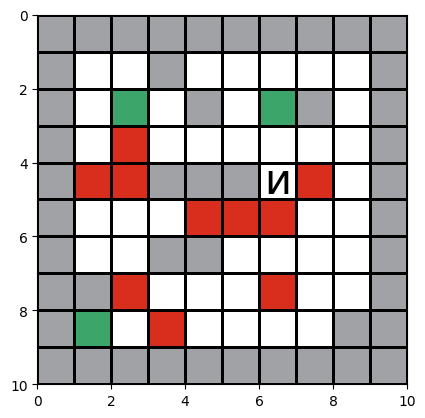

In [46]:
direction_input = "STAY" # @param ["UP", "RIGHT", "DOWN", "LEFT", "STAY"]
# ovo su nam akcije koje nas agent moze da koristi

if direction_input == "UP":
  is_moved = Tabla.move_up()
if direction_input == "DOWN":
  is_moved = Tabla.move_down()
if direction_input == "LEFT":
  is_moved = Tabla.move_left()
if direction_input == "RIGHT":
  is_moved = Tabla.move_right()

showBoardWithGrid(refreshBoard(board))
print("Player current points:" + str(Tabla.get_points()))
print(f"Does i moved: {is_moved}, is terminal = {Tabla.is_cell_terminal()}, and this cell costs {Tabla.get_current_cell_reward()}")

## Implementing algorithm

#### Get states to list from board

In [47]:
states_list = Tabla.get_state_list()

values = {s: random.random() for s in states_list}

for s in values:
    if isinstance(Tabla.board[s[1]][s[0]], TerminalCell):
        values[s] = 0


#### Implementacija algoritma, prvi pokusaj
**NE RADI**

In [48]:
'''
directions = ["UP", "RIGHT", "DOWN", "LEFT"]

eps = 0.1
gamma = 0.5
v = 0;

v_tilda = 0.002
#while v_tilda < eps:
for state in states_dictionary:
  v_explored = []
  Tabla.player_x = state[0]
  Tabla.player_y = state[1]
  for direction in directions:
    r = Tabla.board[state[1]][state[0]].get_reward()
    if direction == "UP":
      is_moved = Tabla.move_up()
      if is_moved:
        if not Tabla.is_cell_terminal():
          v_explored.append( r + gamma*states_dictionary[(state[0], state[1]-1)] )
          Tabla.move_down()
      else:
        v_explored.append(r+gamma*r)
    if direction == "DOWN":
      is_moved = Tabla.move_down()
      if is_moved:
        if not Tabla.is_cell_terminal():
          v_explored.append( r + gamma*states_dictionary[(state[0], state[1]+1)] )
          Tabla.move_up()
      else:
        v_explored.append(r+gamma*r)
    if direction == "LEFT":
      is_moved = Tabla.move_left()
      if is_moved:
        if not Tabla.is_cell_terminal():
          v_explored.append( r + gamma*states_dictionary[(state[0]-1, state[1])] )
          Tabla.move_right()
      else:
        v_explored.append(r+gamma*r)
    if direction == "RIGHT":
      is_moved = Tabla.move_right()
      if is_moved:
        if not Tabla.is_cell_terminal():
          v_explored.append( r + gamma*states_dictionary[(state[0]+1, state[1])] )
          Tabla.move_left()
      else:
        v_explored.append(r+gamma*r)
  v_new = max(v_explored)

  states_dictionary[(state[0], state[1])] = v_new

      #if abs(v_new - states_dictionary[(state_value[0], state_value[1])]) > v_tilda:
      #  v_tilda = abs(v_new - states_dictionary[(state_value[0], state_value[1])])
'''

'\ndirections = ["UP", "RIGHT", "DOWN", "LEFT"]\n\neps = 0.1\ngamma = 0.5\nv = 0;\n\nv_tilda = 0.002\n#while v_tilda < eps:\nfor state in states_dictionary:\n  v_explored = []\n  Tabla.player_x = state[0]\n  Tabla.player_y = state[1]\n  for direction in directions:\n    r = Tabla.board[state[1]][state[0]].get_reward()\n    if direction == "UP":\n      is_moved = Tabla.move_up()\n      if is_moved:\n        if not Tabla.is_cell_terminal():\n          v_explored.append( r + gamma*states_dictionary[(state[0], state[1]-1)] )\n          Tabla.move_down()\n      else:\n        v_explored.append(r+gamma*r)\n    if direction == "DOWN":\n      is_moved = Tabla.move_down()\n      if is_moved:\n        if not Tabla.is_cell_terminal():\n          v_explored.append( r + gamma*states_dictionary[(state[0], state[1]+1)] )\n          Tabla.move_up()\n      else:\n        v_explored.append(r+gamma*r)\n    if direction == "LEFT":\n      is_moved = Tabla.move_left()\n      if is_moved:\n        if not Tab

#### Implementacija algoritma, drugi pokusaj 😍



In [49]:
def compute_v(player_x, player_y, values, gamma):
  rhs = []
  for a in ["UP", "RIGHT", "DOWN", "LEFT"]:
      Tabla.player_x = player_x;
      Tabla.player_y = player_y;
      r = Tabla.get_current_cell_reward()

      if a == "UP":
        Tabla.move_up()
      if a == "DOWN":
        Tabla.move_down()
      if a == "LEFT":
        Tabla.move_left()
      if a == "RIGHT":
        Tabla.move_right()

      rhs.append( r + gamma*values[(Tabla.player_x, Tabla.player_y)] )
  return max(rhs)

In [50]:
def iteration_by_value(number_of_iterations, gamma, values):
  for _ in range(number_of_iterations):
    for s in values:
      Tabla.player_x = s[0];
      Tabla.player_y = s[1];

      if not Tabla.is_cell_terminal():
        values[s] = compute_v(s[0], s[1], values, gamma)
  return values

# Simulating system

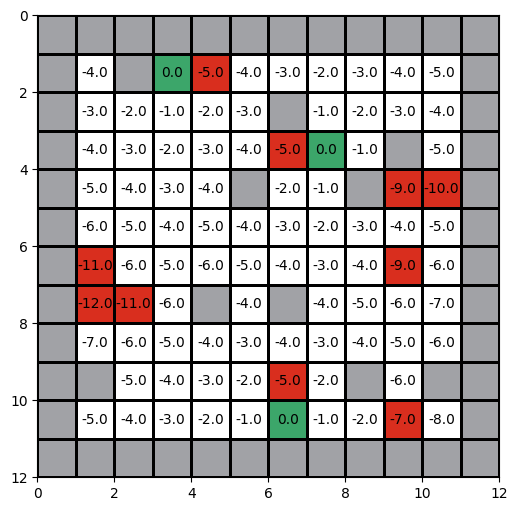

In [56]:
number_of_iterations = 20 # @param {type:"slider", min:1, max:20, step:1}
gamma = 1 # @param {type:"slider", min:0, max:1, step:0.1}
refresh_board = True # @param {type:"boolean"}
show_text = True # @param {type:"boolean"}


ROWS_NUMBER = 12 # @param {type:"integer"}
COLUMNS_NUMBER = 12 # @param {type:"integer"}


if refresh_board == True:
  Tabla, board = generate_map(ROWS_NUMBER, COLUMNS_NUMBER)

states_list = Tabla.get_state_list()

values = {s: random.random() for s in states_list}

for s in values:
    if isinstance(Tabla.board[s[1]][s[0]], TerminalCell):
        values[s] = 0
v = iteration_by_value(number_of_iterations, gamma, values)

showBoardWithGridAndScores(refreshBoard(board), v, show_text, ROWS_NUMBER, COLUMNS_NUMBER)
